In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [210]:
humans = pd.read_csv("data/humans.csv")
machines = pd.read_csv("data/machines.csv")
machines = machines.iloc[machines["text"].drop_duplicates().index]
df = pd.concat([humans,machines])
df.drop(columns=["profundidade_max","profundidade_media"],inplace=True)
variable_mapping = {
    'lexical_density': 'LD',
    'lexical_sophistication': 'LS',
    'ttr': 'TTR',
    'd-measure': 'D',
    'token_quantity': 'token_count'
}
df.rename(columns=variable_mapping, inplace=True)

In [211]:
len(humans)

61

In [212]:
df["type"]

0       False
1       False
2       False
3       False
4       False
        ...  
1323    gpt-4
1324    gpt-4
1325    gpt-4
1326    gpt-4
1327    gpt-4
Name: type, Length: 454, dtype: object

In [213]:
df["type"].unique()

array([False, True, 'gpt-4', 'gpt-3.5-turbo'], dtype=object)

In [214]:
mapp = {x:x for x in df["type"].unique()}
mapp[False] = "not maximum grade"
mapp[True]  = "maximum grade"

In [215]:
df["type"] = df["type"].map(mapp)

In [216]:
df["type"].unique()

array(['not maximum grade', 'maximum grade', 'gpt-4', 'gpt-3.5-turbo'],
      dtype=object)

In [217]:
mapp = {s:"LLM" for s in  df["type"].unique()}
mapp["not maximum grade"] = "human"
mapp["maximum grade"] = "human"
df["model"] = df["type"].map(mapp)

In [218]:
df.sample(11).head()

,MLC,MLS,MLT,DCC,DCT,CPC,CPT,TS,LD,LS,TTR,D,token_count,text,type,model
56,20.666667,44.777778,53.733333,0.615385,1.600000,1.282051,3.333333,0.833333,0.383375,0.981818,0.457698,120.020281,806,"Na obra ""Iracema"", datada do período romântico...",maximum grade,human
632,14.880000,31.000000,93.000000,0.640000,4.000000,2.040000,12.750000,0.333333,0.424731,0.843750,0.515942,118.305612,372,A valorização das comunidades e povos tradicio...,gpt-3.5-turbo,LLM
8,17.774194,34.437500,68.875000,0.677419,2.625000,1.935484,7.500000,0.500000,0.395644,0.897436,0.538618,139.731248,551,Título: A Valorização da Cultura Ancestral: Um...,gpt-4,LLM
1261,15.138889,32.058824,68.125000,0.750000,3.375000,1.083333,4.875000,0.470588,0.387156,0.857143,0.504149,130.161753,545,Dentre as diversas culturas que compõem a iden...,gpt-4,LLM
1129,18.666667,37.333333,62.222222,0.700000,2.333333,2.400000,8.000000,0.600000,0.391071,0.911111,0.442308,105.402142,560,A história do Brasil é marcada pela presença d...,gpt-3.5-turbo,LLM


In [219]:
numeric_columns = df.select_dtypes(include='number').columns
df.groupby("type")[numeric_columns].agg(["mean", "std"]).round(1)

MLC        MLS         MLT        DCC       DCT       ...  \
                   mean  std  mean   std  mean   std mean  std mean  std  ...   
type                                                                      ...   
gpt-3.5-turbo      21.7  4.5  34.9   5.0  97.3  40.8  0.7  0.1  3.2  1.7  ...   
gpt-4              21.0  4.1  32.4   5.2  57.9  16.4  0.7  0.1  1.9  0.6  ...   
maximum grade      19.7  3.9  43.4   7.2  59.5  13.9  0.7  0.1  2.2  0.8  ...   
not maximum grade  16.7  4.8  37.4  10.4  58.9  23.5  0.6  0.1  2.4  1.5  ...   

                    LD        LS       TTR           D       token_count  \
                  mean  std mean  std mean  std   mean   std        mean   
type                                                                       
gpt-3.5-turbo      0.4  0.0  0.9  0.0  0.5  0.0  105.7  11.7       480.5   
gpt-4              0.4  0.0  0.9  0.0  0.5  0.0  127.6  16.8       537.3   
maximum grade      0.4  0.0  0.9  0.0  0.5  0.0  113.5  11.5       650.0   
not maximum grade  0.4  0.0  0.9  0.0  0.5  0.1  136.2  26.7       412.8   

                          
                     std  
type                      
gpt-3.5-turbo       62.8  
gpt-4               59.6  
maximum grade       80.5  
not maximum grade  120.7  

[4 rows x 26 columns]

In [220]:
# sns.pairplot(df,hue="model",diag_kind = "kde")

In [221]:
# sns.pairplot(df,hue="type")

In [222]:
mapp = {s:"LLM" for s in  df["type"].unique()}
mapp["not maximum grade"] = "human"
mapp["maximum grade"] = "human"
df["model"] = df["type"].map(mapp)

In [231]:
df["class"] = ((df["model"] == "LLM") * df["type"]) + ((df["model"] != "LLM") * df["model"]) 

In [263]:
from scipy.stats import ttest_ind
from scipy.stats import anderson


grouped_data = df.groupby('class')

group1 = grouped_data.get_group("human")
group2 = grouped_data.get_group("gpt-3.5-turbo")

ttest_results = {
    'Feature': [],
    'T-Statistic': [],
    'P-Value': [],
    'Significant': [],
    'Normality': []
}
for column in df.select_dtypes(include='number').columns:
    # Extract the data for each group for the current column
    data1 = group1[column]
    data2 = group2[column].sample(30)
    
    # Perform the t-test
    t_stat, p_value = ttest_ind(data1, data2)
    
    # Determine if the result is significant (p-value < 0.05)
    significant = p_value < 0.05

    normal = anderson(data1, 'norm').statistic < 0.05
    
    # Store the results in the dictionary
    ttest_results['Feature'].append(column)
    ttest_results['T-Statistic'].append(t_stat)
    ttest_results['P-Value'].append(p_value)
    ttest_results['Significant'].append(significant)
    ttest_results['Normality'].append(normal)

In [264]:
results_df = pd.DataFrame(ttest_results)
results_df.sort_values(by = 'Significant',inplace=True)
results_df

,Feature,T-Statistic,P-Value,Significant,Normality
3,DCC,-0.437846,6.625586e-01,False,False
9,LS,-0.782360,4.360799e-01,False,False
12,token_count,1.393021,1.670833e-01,False,False
0,MLC,-3.487877,7.587892e-04,True,False
1,MLS,2.732039,7.590492e-03,True,False
2,MLT,-6.132210,2.333036e-08,True,False
4,DCT,-2.723137,7.781580e-03,True,False
5,CPC,-10.741882,9.531313e-18,True,False
6,CPT,-10.205895,1.204081e-16,True,False
7,TS,10.578761,2.058931e-17,True,False


In [265]:
significant_ones = results_df[results_df["Significant"]== True]
significant_ones

,Feature,T-Statistic,P-Value,Significant,Normality
0,MLC,-3.487877,7.587892e-04,True,False
1,MLS,2.732039,7.590492e-03,True,False
2,MLT,-6.132210,2.333036e-08,True,False
4,DCT,-2.723137,7.781580e-03,True,False
5,CPC,-10.741882,9.531313e-18,True,False
6,CPT,-10.205895,1.204081e-16,True,False
7,TS,10.578761,2.058931e-17,True,False
8,LD,-2.241339,2.749128e-02,True,False
10,TTR,6.170147,1.972666e-08,True,False
11,D,3.744787,3.198491e-04,True,False


In [266]:
# for feature in significant_ones["Feature"]: 
#     plt.figure(figsize=(10, 6))  # Set figure size
#     ax = sns.displot(data=df, x=feature,hue="type",kind="kde",common_norm=False)
#     plt.show()

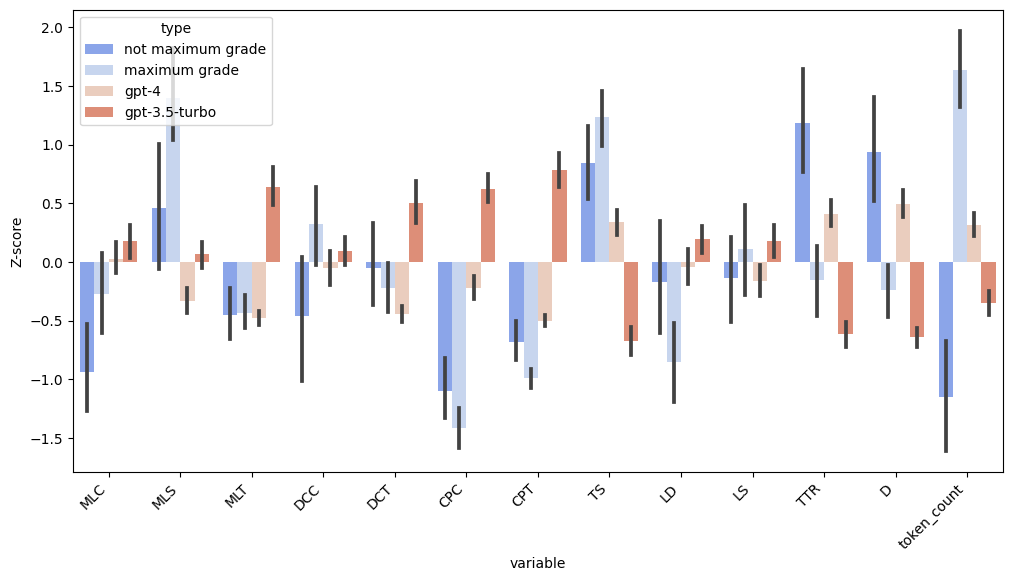

In [267]:
# Plotting
z_scores = df[df.select_dtypes(include='number').columns].apply(lambda x: (x - x.mean()) / x.std())
z_scores["type"] = df["type"]
z_scores_melted  = z_scores.melt(id_vars="type", var_name="variable", value_name="z_score")
plt.figure(figsize=(12, 6))
sns.barplot(data=z_scores_melted, x="variable", y="z_score", hue="type", palette="coolwarm",errorbar="ci")
# plt.xlabel("Variable")
plt.ylabel("Z-score")
# plt.title("Z-score of each variable for each type")
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
plt.show()


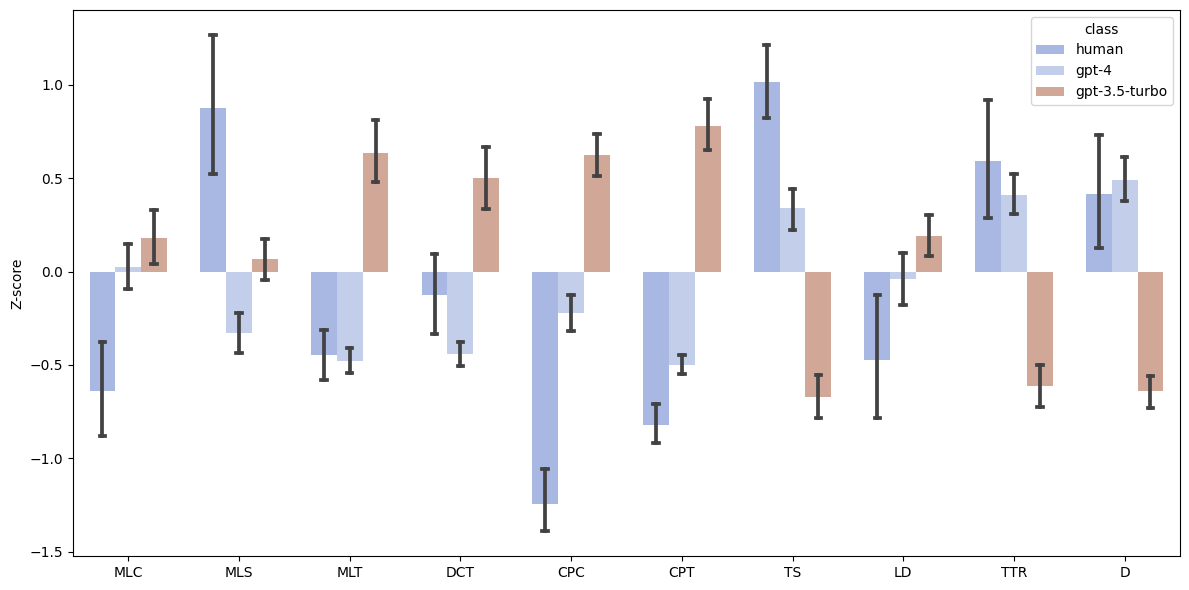

In [268]:
# Plotting
z_scores = df[significant_ones["Feature"]].apply(lambda x: (x - x.mean()) / x.std())
z_scores["class"] = df["class"]
z_scores_melted  = z_scores.melt(id_vars="class", var_name="variable", value_name="z_score")
plt.figure(figsize=(12, 6))

hue_order = ["human", "gpt-4", "gpt-3.5-turbo"]

custom_palette = ["#A0B4EB", "#BDCBF1", "#DBA38D"]  # Example colors

sns.barplot(data=z_scores_melted, x="variable", y="z_score", hue="class", 
            palette=custom_palette,
            hue_order=hue_order,
            errorbar="ci", capsize=.05,
            width=0.7)
plt.xlabel("")
plt.ylabel("Z-score")
plt.tight_layout()
plt.show()
